## 1. Setting the frame

In [1]:
#Importing the required libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#Checking the dataset

data = pd.read_csv('train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 2. Cleaning the dataset

In [3]:
#Taking some more information about the dataset

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

It seems that some columns have null values present in them. Inspecting the values:

In [4]:
#Checking for percentage of null values in each column

round(data.isnull().sum()/len(data.index),2).sort_values(ascending=False).head(20)

PoolQC          1.00
MiscFeature     0.96
Alley           0.94
Fence           0.81
FireplaceQu     0.47
LotFrontage     0.18
GarageYrBlt     0.06
GarageFinish    0.06
GarageType      0.06
GarageQual      0.06
GarageCond      0.06
BsmtExposure    0.03
BsmtQual        0.03
BsmtCond        0.03
BsmtFinType2    0.03
BsmtFinType1    0.03
MasVnrType      0.01
MasVnrArea      0.01
Id              0.00
Functional      0.00
dtype: float64

Observing the dataset, let's take the threshold for missing values in a column to be 6%, beyond which, we would not consider the columns fit for analysis because of missing data. 
We shall drop the columns 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage'.


In [5]:
data = data.drop(['LotFrontage','Alley','FireplaceQu','PoolQC','Fence','MiscFeature'],axis='columns')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

Amongst the columns, a more meaningful way of looking at the data is to find out how old is the property instead of the year in which it was construced, remodelled and sold. Hence, we convert the columns into the age of the property and remove the previous columns which are unnecessary at the outset.

In [7]:
data['YearBuilt_age'] = data.YearBuilt.max()-data.YearBuilt
data['YearRemodAdd_age'] = data.YearRemodAdd.max()-data.YearRemodAdd
data['YrSold_age'] = data.YrSold.max()-data.YrSold
data['GarageYrBlt_age'] = data.GarageYrBlt.max()-data.GarageYrBlt
data[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','YearBuilt_age','YearRemodAdd_age', 'GarageYrBlt_age','YrSold_age']].sample(5)

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,YearBuilt_age,YearRemodAdd_age,GarageYrBlt_age,YrSold_age
949,1972,2006,1972.0,2010,38,4,38.0,0
62,2006,2006,2006.0,2007,4,4,4.0,3
343,2005,2005,2005.0,2008,5,5,5.0,2
453,2008,2008,2008.0,2009,2,2,2.0,1
480,2004,2005,2004.0,2006,6,5,6.0,4


Removing the unnecessary year columns including the 'Id', 'Street' & 'Utilities', which is unnecessary

In [8]:
data = data.drop(['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold', 'Id'],axis=1)

In [9]:
# Looking into the dataset
data.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,YearBuilt_age,YearRemodAdd_age,YrSold_age,GarageYrBlt_age
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,2,WD,Normal,208500,7,7,2,7.0
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,5,WD,Normal,181500,34,34,3,34.0
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,9,WD,Normal,223500,9,8,2,9.0
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,0,0,2,WD,Abnorml,140000,95,40,4,12.0
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,12,WD,Normal,250000,10,10,2,10.0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 74 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MSSubClass        1460 non-null   int64  
 1   MSZoning          1460 non-null   object 
 2   LotArea           1460 non-null   int64  
 3   Street            1460 non-null   object 
 4   LotShape          1460 non-null   object 
 5   LandContour       1460 non-null   object 
 6   Utilities         1460 non-null   object 
 7   LotConfig         1460 non-null   object 
 8   LandSlope         1460 non-null   object 
 9   Neighborhood      1460 non-null   object 
 10  Condition1        1460 non-null   object 
 11  Condition2        1460 non-null   object 
 12  BldgType          1460 non-null   object 
 13  HouseStyle        1460 non-null   object 
 14  OverallQual       1460 non-null   int64  
 15  OverallCond       1460 non-null   int64  
 16  RoofStyle         1460 non-null   object 


Because there are some columns with missing values, less than 6%, we would be imputing the missing values in the necessary context, in sequential order.

In [11]:
data.MasVnrType.fillna('None',inplace=True)
data.MasVnrArea.fillna(data.MasVnrArea.mean(),inplace=True) #Imputing missing area with mean, which is an ideal filling here.

data.BsmtQual.fillna('TA',inplace = True)
data.BsmtCond.fillna('TA',inplace = True)
data.BsmtExposure.fillna('No',inplace = True)
data.BsmtFinType1.fillna('Unf',inplace = True)
data.BsmtFinType2.fillna('Unf',inplace = True)

data.Electrical.fillna('Yes', inplace = True)

data.GarageType.fillna('Attchd',inplace = True)
data.GarageFinish.fillna('Unf',inplace = True)

data.GarageQual.fillna('TA',inplace = True)
data.GarageCond.fillna('TA',inplace = True)

data.GarageYrBlt_age.fillna(0,inplace = True) #We replace the place as 0 for the houses without garage

In [12]:
#Check for null values again

round(data.isnull().sum()/len(data.index),2).sort_values(ascending=False).head()

MSSubClass      0.0
GarageArea      0.0
GarageFinish    0.0
GarageType      0.0
Fireplaces      0.0
dtype: float64

Hence, we can say, there is no missing values remaining in the dataset. All the null values are taken care of. Let's perform some EDA on the dataset now.

## 3. Exploratory Data Analysis

In [13]:
# Extracting the Year Features from the Dataset and then checking how the price varies with respect to the age of the estate
yr_cols = []
for i in data.columns:
    if 'Yr' in i or 'Year' in i or 'year' in i or 'yr' in i:
        yr_cols.append(i)
print('List of features with Year are:')
print(yr_cols)

List of features with Year are:
['YearBuilt_age', 'YearRemodAdd_age', 'YrSold_age', 'GarageYrBlt_age']


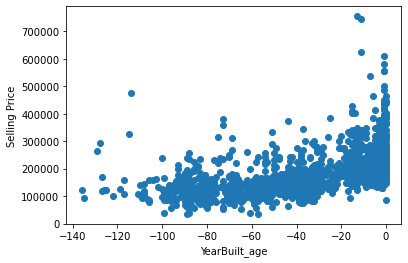

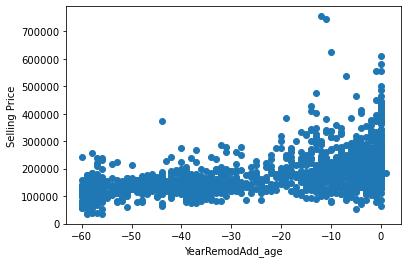

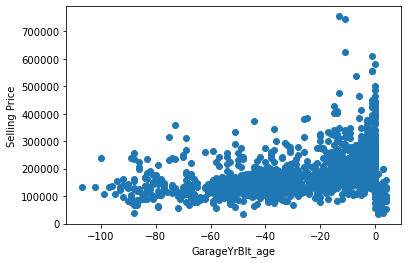

In [14]:
# Comparing the Age of the Building / Renovated Building / Garage with the Sold Price
for feature in yr_cols:
    if feature!='YrSold_age':
        data=data.copy()
        data[feature]=data['YrSold_age']-data[feature]
        plt.scatter(data[feature],data['SalePrice'])
        plt.xlabel(feature)
        plt.ylabel('Selling Price')
        plt.show()

From the above graphs, it seems pretty obvious that as properties age, the price reduces.

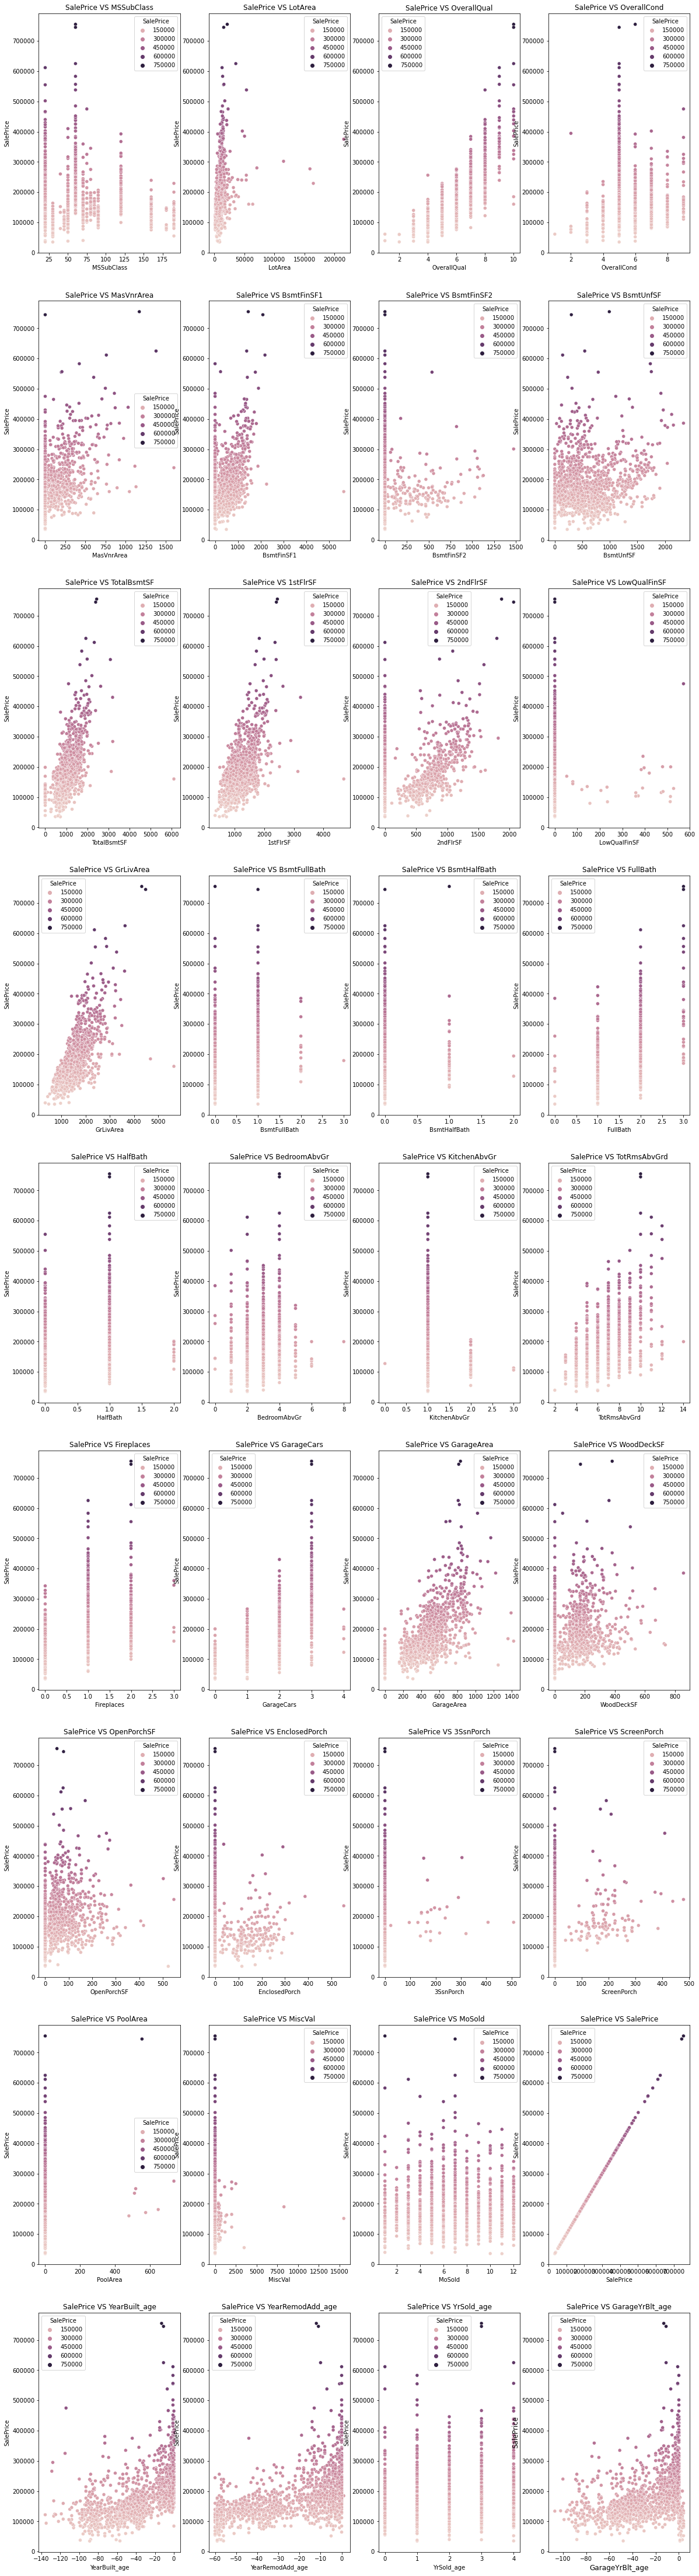

In [15]:
#Visualising numerical predictor variables with Target Variables
data_num = data.select_dtypes(include=['int64','float64'])
fig,axs= plt.subplots(9,4,figsize=(20,80))
for i,ax in zip(data_num.columns,axs.flatten()):
    sns.scatterplot(x=i, y='SalePrice', hue='SalePrice',data=data_num,ax=ax)
    plt.xlabel(i,fontsize=12)
    plt.ylabel('SalePrice',fontsize=12)
    ax.set_title('SalePrice'+' VS '+str(i))

Observations from the above plot:-

- New properties are costlier than older properties.
- GRLiving Area has a direct corelation with the proce of the property.
- Total basement area, which is linearly related with the total living area, also is directly proportional to the price of the property.
- Month sold has no effect on the price.


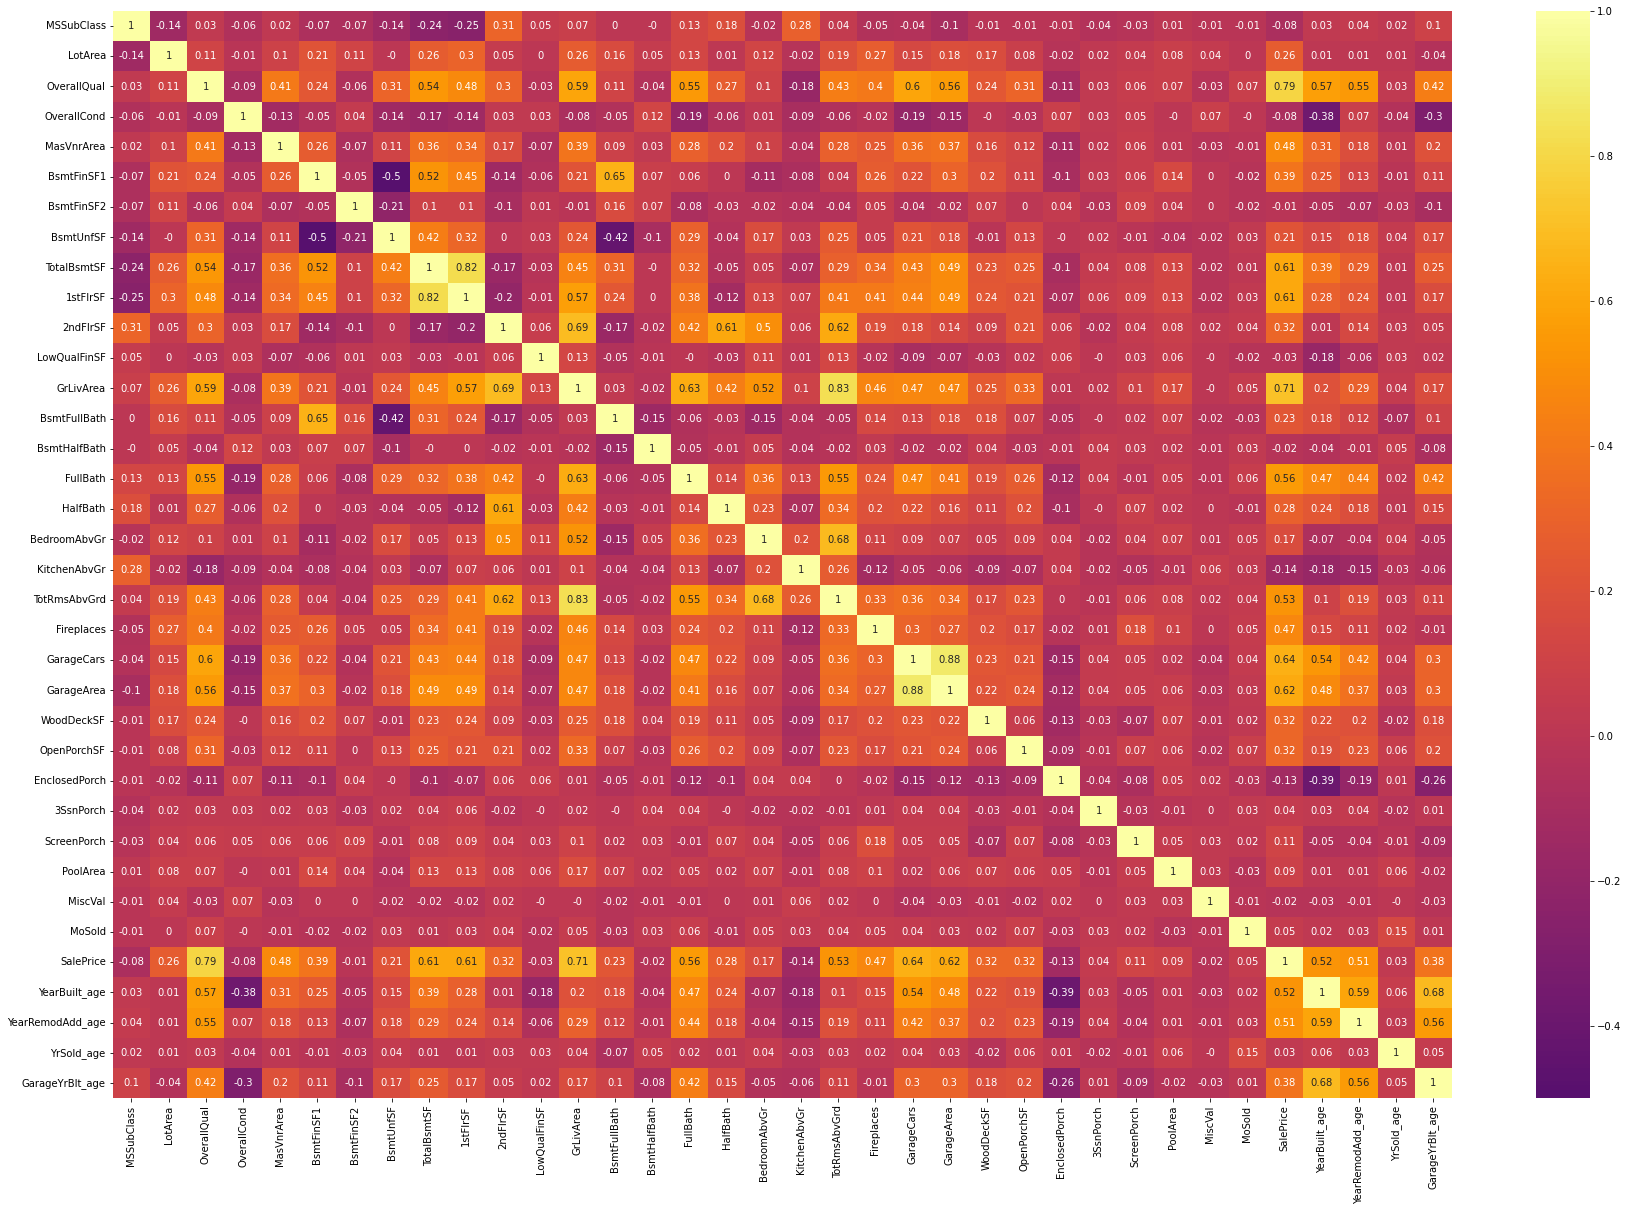

In [16]:
# Checking the corelation
plt.subplots(figsize = (30,20))

#Plotting heatmap of numerical features
sns.heatmap(round(data_num.corr(),2), cmap='inferno' , annot=True, center = 0)
plt.show()

Now we should drop outliers beyond the quantile range (0.25 to 0.95) as these may interfere in our assessments

In [17]:
num_col = list(data.dtypes[data.dtypes !='object'].index)
num_col = ['LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','1stFlrSF','GrLivArea','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch' ,'PoolArea','MiscVal','SalePrice']
def drop_outliers(x):
    list = []
    for col in num_col:
        Q1 = x[col].quantile(.25)
        Q3 = x[col].quantile(0.95)
        IQR = Q3-Q1
        x =  x[(x[col] >= (Q1-(1.5*IQR))) & (x[col] <= (Q3+(1.5*IQR)))] 
    return x   

data = drop_outliers(data)

In [18]:
data.describe()

,MSSubClass,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,YearBuilt_age,YearRemodAdd_age,YrSold_age,GarageYrBlt_age
count,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.00000,1342.000000,1342.000000,1342.000000,1342.000000,...,1342.0,1342.000000,1342.0,1342.0,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000
mean,57.481371,9546.786885,6.089419,5.554396,99.797166,426.19225,39.134873,575.828614,1041.155738,1145.582712,...,0.0,13.541729,0.0,0.0,6.319672,178211.234724,-36.145306,-22.822653,2.188525,-27.281669
std,42.571053,3884.679655,1.371183,1.096918,166.357870,426.24540,136.028243,444.960500,401.364654,362.823420,...,0.0,50.351258,0.0,0.0,2.699720,74566.753421,30.457568,20.812070,1.323595,25.299275
min,20.000000,1300.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,334.000000,...,0.0,0.000000,0.0,0.0,1.000000,35311.000000,-136.000000,-60.000000,0.000000,-107.000000
25%,20.000000,7416.250000,5.000000,5.000000,0.000000,0.00000,0.000000,231.000000,793.000000,872.500000,...,0.0,0.000000,0.0,0.0,5.000000,129000.000000,-54.750000,-41.000000,1.000000,-46.000000
50%,50.000000,9298.500000,6.000000,5.000000,0.000000,366.50000,0.000000,485.000000,980.000000,1074.500000,...,0.0,0.000000,0.0,0.0,6.000000,160000.000000,-34.000000,-14.000000,2.000000,-22.500000
75%,70.000000,11365.750000,7.000000,6.000000,163.750000,700.00000,0.000000,813.000000,1270.500000,1368.000000,...,0.0,0.000000,0.0,0.0,8.000000,210750.000000,-7.000000,-4.000000,3.000000,-4.000000
max,190.000000,31770.000000,10.000000,9.000000,1047.000000,2188.00000,972.000000,2336.000000,3094.000000,2898.000000,...,0.0,385.000000,0.0,0.0,12.000000,611657.000000,0.000000,0.000000,4.000000,4.000000


In [19]:
data.head(10) #Seeing the data

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,YearBuilt_age,YearRemodAdd_age,YrSold_age,GarageYrBlt_age
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,2,WD,Normal,208500,-5,-5,2,-5.0
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,5,WD,Normal,181500,-31,-31,3,-31.0
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,9,WD,Normal,223500,-7,-6,2,-7.0
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,0,0,2,WD,Abnorml,140000,-91,-36,4,-8.0
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,12,WD,Normal,250000,-8,-8,2,-8.0
6,20,RL,10084,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,...,0,0,8,WD,Normal,307000,-3,-2,3,-3.0
8,50,RM,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,...,0,0,4,WD,Abnorml,129900,-77,-58,2,-77.0
9,190,RL,7420,Pave,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,...,0,0,1,WD,Normal,118000,-69,-58,2,-69.0
10,20,RL,11200,Pave,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,...,0,0,2,WD,Normal,129500,-43,-43,2,-43.0
11,60,RL,11924,Pave,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,...,0,0,7,New,Partial,345000,-1,0,4,-1.0


__'LandSlope','ExterQual','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2', 'HeatingQC','CentralAir',  'KitchenQual','GarageFinish','GarageQual','GarageCond','ExterCond','LotShape'__

These columns are categorical in nature and it can be used if converted into numerical variables. Let's have some more insight into these columns.

In [20]:
data[['LandSlope','ExterQual','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2', 'HeatingQC','CentralAir',  'KitchenQual','GarageFinish','GarageQual','GarageCond','ExterCond','LotShape']].head(10)

,LandSlope,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,GarageFinish,GarageQual,GarageCond,ExterCond,LotShape
0,Gtl,Gd,Gd,TA,No,GLQ,Unf,Ex,Y,Gd,RFn,TA,TA,TA,Reg
1,Gtl,TA,Gd,TA,Gd,ALQ,Unf,Ex,Y,TA,RFn,TA,TA,TA,Reg
2,Gtl,Gd,Gd,TA,Mn,GLQ,Unf,Ex,Y,Gd,RFn,TA,TA,TA,IR1
3,Gtl,TA,TA,Gd,No,ALQ,Unf,Gd,Y,Gd,Unf,TA,TA,TA,IR1
4,Gtl,Gd,Gd,TA,Av,GLQ,Unf,Ex,Y,Gd,RFn,TA,TA,TA,IR1
6,Gtl,Gd,Ex,TA,Av,GLQ,Unf,Ex,Y,Gd,RFn,TA,TA,TA,Reg
8,Gtl,TA,TA,TA,No,Unf,Unf,Gd,Y,TA,Unf,Fa,TA,TA,Reg
9,Gtl,TA,TA,TA,No,GLQ,Unf,Ex,Y,TA,RFn,Gd,TA,TA,Reg
10,Gtl,TA,TA,TA,No,Rec,Unf,Ex,Y,TA,Unf,TA,TA,TA,Reg
11,Gtl,Ex,Ex,TA,No,GLQ,Unf,Ex,Y,Ex,Fin,TA,TA,TA,IR1


Replacing it by numerical variables, we have:

In [21]:
data['LandSlope'] = data.LandSlope.map({'Gtl':0,'Mod':1,'Sev':2})
data['ExterQual'] = data.ExterQual.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
data['BsmtQual'] = data.BsmtQual.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
data['BsmtCond'] = data.BsmtCond.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
data['BsmtExposure'] = data.BsmtExposure.map({'NA':0,'No':1,'Mn':2,'Av':3,'Gd':4})
data['BsmtFinType1'] = data.BsmtFinType1.map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
data['BsmtFinType2'] = data.BsmtFinType2.map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
data['HeatingQC'] = data.HeatingQC.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
data['CentralAir'] = data.CentralAir.map({'N':0,'Y':1})
data['KitchenQual'] = data.KitchenQual.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
data['GarageFinish'] = data.GarageFinish.map({'NA':0,'Unf':1,'RFn':2,'Fin':3})
data['GarageQual'] = data.GarageQual.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
data['GarageCond'] = data.GarageCond.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
data['ExterCond'] = data.ExterCond.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
data['LotShape'] = data.LotShape.map({'IR1':0,'IR2':1,'IR3':2,'Reg':3})

In [22]:
#Looking at the dataset after conversion
data[['LandSlope','ExterQual','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2', 'HeatingQC','CentralAir',  'KitchenQual','GarageFinish','GarageQual','GarageCond','ExterCond','LotShape']].head(10)

,LandSlope,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,GarageFinish,GarageQual,GarageCond,ExterCond,LotShape
0,0,3,4,3,1,6,1,4,1,3,2,3,3,2,3
1,0,2,4,3,4,5,1,4,1,2,2,3,3,2,3
2,0,3,4,3,2,6,1,4,1,3,2,3,3,2,0
3,0,2,3,4,1,5,1,3,1,3,1,3,3,2,0
4,0,3,4,3,3,6,1,4,1,3,2,3,3,2,0
6,0,3,5,3,3,6,1,4,1,3,2,3,3,2,3
8,0,2,3,3,1,1,1,3,1,2,1,2,3,2,3
9,0,2,3,3,1,6,1,4,1,2,2,4,3,2,3
10,0,2,3,3,1,3,1,4,1,2,1,3,3,2,3
11,0,4,5,3,1,6,1,4,1,4,3,3,3,2,0


Now we need to join the dummy column with the dataset.

In [23]:
dummy_col = pd.get_dummies(data[['MSZoning','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st', 'Exterior2nd','MasVnrType','Foundation','Heating','Electrical','Functional','GarageType','PavedDrive','SaleType','SaleCondition']],drop_first=True)

In [24]:
data = pd.concat([data,dummy_col],axis='columns') #Concatenating the converted values with the actual tables

In [25]:
#Dropping the categorical columns which have been converted into numerical ones
data = data.drop(['MSZoning','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st',  'Exterior2nd','MasVnrType','Foundation','Heating','Electrical','Functional','GarageType','PavedDrive','SaleType','SaleCondition'],axis='columns')

In [26]:
#Let's look at our data
data.head()

,MSSubClass,LotArea,Street,LotShape,Utilities,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,8450,Pave,3,AllPub,0,7,5,196.0,3,...,0,0,0,0,1,0,0,0,1,0
1,20,9600,Pave,3,AllPub,0,6,8,0.0,2,...,0,0,0,0,1,0,0,0,1,0
2,60,11250,Pave,0,AllPub,0,7,5,162.0,3,...,0,0,0,0,1,0,0,0,1,0
3,70,9550,Pave,0,AllPub,0,7,5,0.0,2,...,0,0,0,0,1,0,0,0,0,0
4,60,14260,Pave,0,AllPub,0,8,5,350.0,3,...,0,0,0,0,1,0,0,0,1,0


Let's remove 'Street' and 'Utilities' columns as they are unimportant at this outset

In [27]:
data= data.drop(['Street','Utilities'], axis=1)

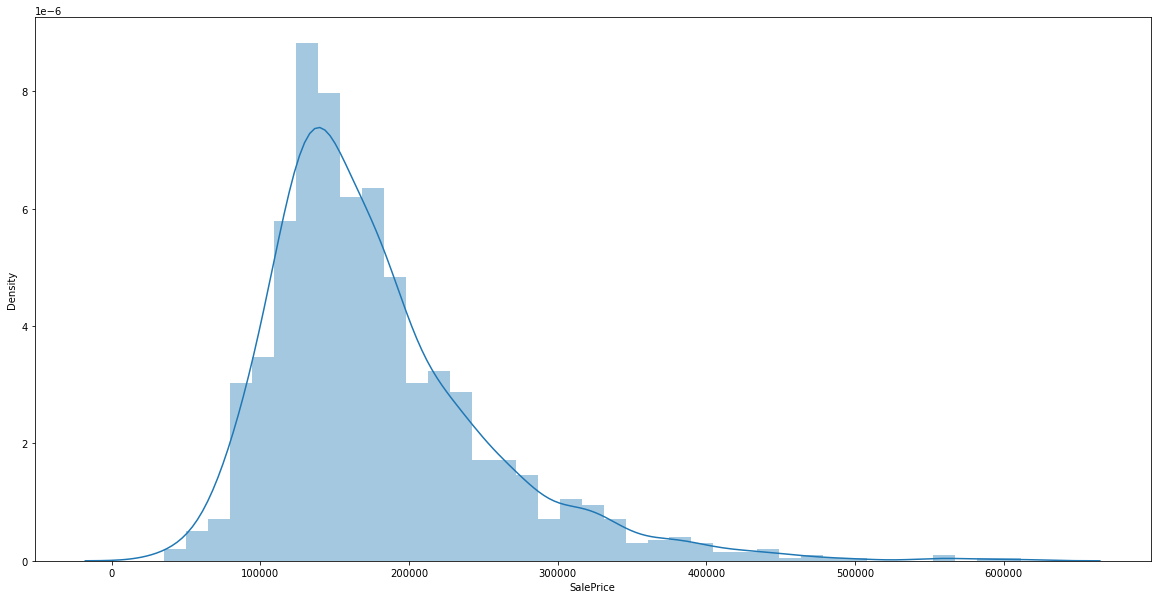

In [28]:
#Seeing the data distribution of our target variable
plt.figure(figsize=(20,10))
sns.distplot(data.SalePrice)
plt.show()

## 4. Building a model

Now, we would be creating the training and testing dataset.

In [29]:
#splitting the dataset into 75:25 ratio in training and testing set
data_train,data_test = train_test_split(data,train_size=0.75,test_size=0.25,random_state=77)

Now we would be scaling the train dataset because of the difference of scale of dependent and independent variable.

In [30]:
col = ['MSSubClass','LotArea','OverallQual','OverallCond','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','SalePrice']

scaler = StandardScaler()
data_train[col] = scaler.fit_transform(data_train[col])
data_test[col] = scaler.transform(data_test[col])


Let's have a check on the distribution to confirm whether it is scaled.

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

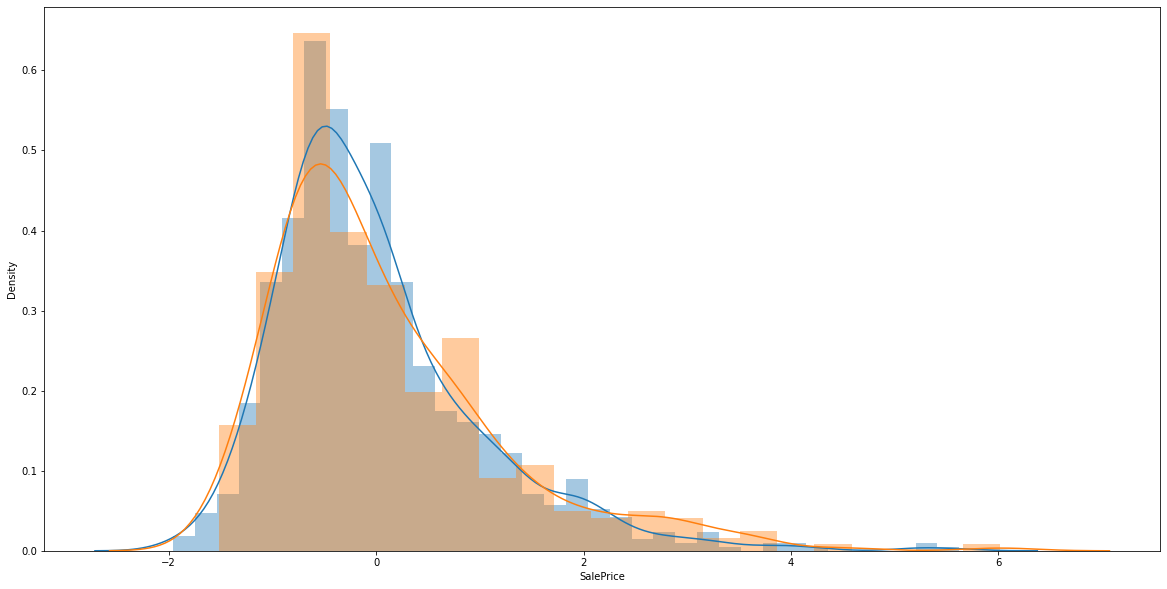

In [31]:
plt.figure(figsize=(20,10))
plt.subplot()
sns.distplot(data_train.SalePrice)
plt.subplot()
sns.distplot(data_test.SalePrice)

It is fairly obvious that the saleprice in both the training and testing datasets have been scaled. Now we would be splitting the training and testing datasets.

In [32]:
#Segregation of dependent and independent variable of the training dataset
y_train = data_train.pop('SalePrice')
X_train = data_train

In [33]:
#Segregation of dependent and independent variable of the testing dataset
y_test = data_test.pop('SalePrice')
X_test = data_test

Let's use Recursive Feature Elimination (RFE) on the training set now with 80 features, a little less than half of the actual number of columns in the dataset.

In [34]:
lm  = LinearRegression()
lm.fit(X_train,y_train)

rfe = RFE(lm,80)
rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=80)

In [35]:
rfe_scores = pd.DataFrame(list(zip(X_train.columns,rfe.support_,rfe.ranking_)))
rfe_scores.columns = ['Column_Names','Status','Rank']

In [36]:
rfe_sel_columns = list(rfe_scores[rfe_scores.Status==True].Column_Names)

In [37]:
#Filtering the training and testing set for the columns selected by RFE
X_train = X_train[rfe_sel_columns]
X_test = X_test[rfe_sel_columns]

### Now let's fit the Lasso regression model first

In [38]:
lm = Lasso(alpha=0.01)
lm.fit(X_train,y_train)

y_train_pred = lm.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred  = lm.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.8747903742172105
0.83622460006226


Now, in the model built by Lasso regression, let's check the coefficients of variables to see the dependent variables and their dependency on independent variable.

In [39]:
model_param = list(lm.coef_)
model_param.insert(0,lm.intercept_)
model_param = [round(x,4) for x in model_param]
col = data_train.columns
col.insert(0,'Constant')
list(zip(col,model_param))

[('MSSubClass', -1.2797),
 ('LotArea', 0.2693),
 ('LotShape', 0.1948),
 ('LandSlope', 0.1176),
 ('OverallQual', 0.01),
 ('OverallCond', -0.0),
 ('MasVnrArea', 0.1181),
 ('ExterQual', 0.0419),
 ('ExterCond', 0.0),
 ('BsmtQual', -0.0347),
 ('BsmtCond', 0.3442),
 ('BsmtExposure', 0.1883),
 ('BsmtFinType1', -0.0),
 ('BsmtFinSF1', -0.0),
 ('BsmtFinType2', -0.0),
 ('BsmtFinSF2', -0.0),
 ('BsmtUnfSF', 0.0),
 ('TotalBsmtSF', -0.0),
 ('HeatingQC', -0.0),
 ('CentralAir', -0.0),
 ('1stFlrSF', -0.0),
 ('2ndFlrSF', -0.0),
 ('LowQualFinSF', 0.256),
 ('GrLivArea', -0.0354),
 ('BsmtFullBath', -0.0),
 ('BsmtHalfBath', 0.0),
 ('FullBath', -0.0),
 ('HalfBath', 0.0),
 ('BedroomAbvGr', 0.0061),
 ('KitchenAbvGr', 0.0),
 ('KitchenQual', -0.0),
 ('TotRmsAbvGrd', 0.0),
 ('Fireplaces', -0.0),
 ('GarageFinish', 0.0),
 ('GarageCars', 0.0),
 ('GarageArea', -0.0),
 ('GarageQual', -0.0),
 ('GarageCond', -0.0),
 ('WoodDeckSF', 0.0),
 ('OpenPorchSF', -0.0),
 ('EnclosedPorch', -0.0),
 ('3SsnPorch', -0.0721),
 ('ScreenP

Let's try to improve our model with GridSearchCV now, as the results with Lasso regression with the assumed value of hyperparameter has not been satisfactory enough.

In [40]:
folds = KFold(n_splits=15,shuffle=True,random_state=77)

In [41]:
hyper_param = {'alpha':[0.001, 0.01, 0.1,1.0, 5.0, 10.0,20.0]} #Selecting the range of alpha for introducing hyperparameters

In [42]:
model = Lasso()
model_cv = GridSearchCV(estimator = model,param_grid=hyper_param,scoring='r2',cv=folds,verbose=1,return_train_score=True)

#Fitting the model
model_cv.fit(X_train,y_train)

Fitting 15 folds for each of 7 candidates, totalling 105 fits


GridSearchCV(cv=KFold(n_splits=15, random_state=77, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [43]:
cv_res = pd.DataFrame(model_cv.cv_results_)
cv_res['param_alpha'] = cv_res['param_alpha'].astype('float32')
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,split12_train_score,split13_train_score,split14_train_score,mean_train_score,std_train_score
0,0.023559,0.001123,0.001097,0.000140,0.001,{'alpha': 0.001},0.820503,0.910801,0.875119,0.886071,...,0.908366,0.905454,0.906851,0.904724,0.904015,0.906751,0.904104,0.908211,0.906785,0.002422
1,0.003605,0.000119,0.001040,0.000327,0.010,{'alpha': 0.01},0.776250,0.879346,0.848928,0.869305,...,0.878086,0.873666,0.874273,0.872813,0.871963,0.875474,0.871666,0.876314,0.875194,0.002676
2,0.002204,0.000085,0.000919,0.000021,0.100,{'alpha': 0.1},0.715066,0.783424,0.824234,0.849874,...,0.818678,0.811676,0.815011,0.815194,0.809968,0.818049,0.812449,0.816876,0.816062,0.003622
3,0.001824,0.000071,0.000925,0.000041,1.000,{'alpha': 1.0},-0.027634,-0.029203,-0.000093,-0.035742,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.001837,0.000061,0.000945,0.000067,5.000,{'alpha': 5.0},-0.027634,-0.029203,-0.000093,-0.035742,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


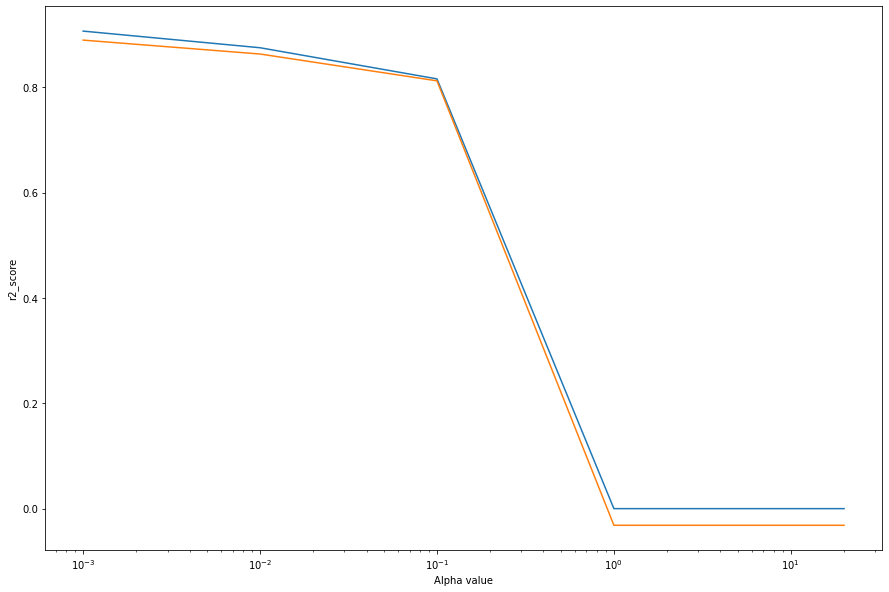

In [44]:
plt.figure(figsize=(15,10))
plt.plot(cv_res['param_alpha'],cv_res['mean_train_score'])
plt.plot(cv_res['param_alpha'],cv_res['mean_test_score'])

plt.xscale('log') #Applying the logarithmic scale for a better insight
plt.ylabel('r2_score')
plt.xlabel('Alpha value')
plt.show()

Now let's check for the best hyperparameter alpha.

In [45]:
model_cv.best_params_

{'alpha': 0.001}

Fitting the model with Lasso regression with the alpha = 0.001

In [46]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

print(r2_score(y_true=y_train,y_pred=y_train_pred))
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.9062339879172692
0.8633914932516361


### Let's try ridge regression now

In [47]:
#Fitting the model with ridge regression with an alpha value of 0.001
ridge = Ridge(alpha=0.001)
ridge.fit(X_train,y_train)

y_train_pred = ridge.predict(X_train)
print(r2_score(y_train,y_train_pred))
y_test_pred = ridge.predict(X_test)
print(r2_score(y_test,y_test_pred))

0.9142183994576738
0.8646943331022929


Let's try to improve the model using GridSearchCV as before.

In [48]:
folds  = KFold(n_splits=15,shuffle=True,random_state=77)

In [49]:
hyper_param = {'alpha':[0.001,0.01,0.1,0.5,1.0, 5.0, 10.0,20.0]}

In [50]:
model = Ridge()
model_cv = GridSearchCV(estimator=model,param_grid=hyper_param,scoring='r2',cv=folds,verbose=1,return_train_score=True)
model_cv.fit(X_train,y_train)

Fitting 15 folds for each of 8 candidates, totalling 120 fits


GridSearchCV(cv=KFold(n_splits=15, random_state=77, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0,
                                   20.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [51]:
cv_res_2 = pd.DataFrame(model_cv.cv_results_)
cv_res_2['param_alpha'] = cv_res_2['param_alpha'].astype('float32')
cv_res_2.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,split12_train_score,split13_train_score,split14_train_score,mean_train_score,std_train_score
0,0.002253,0.000314,0.001024,0.000262,0.001,{'alpha': 0.001},0.830489,0.90795,0.856808,0.895573,...,0.916381,0.913362,0.914413,0.912475,0.912253,0.914834,0.912306,0.916595,0.914758,0.002593
1,0.002150,0.000248,0.001025,0.000215,0.010,{'alpha': 0.01},0.830531,0.90811,0.857622,0.895584,...,0.916380,0.913361,0.914412,0.912475,0.912253,0.914833,0.912305,0.916595,0.914757,0.002593
2,0.002092,0.000234,0.000999,0.000176,0.100,{'alpha': 0.1},0.830882,0.90950,0.863741,0.895623,...,0.916337,0.913309,0.914370,0.912433,0.912206,0.914787,0.912259,0.916543,0.914711,0.002590
3,0.002036,0.000160,0.001004,0.000200,0.500,{'alpha': 0.5},0.831489,0.91289,0.873622,0.895116,...,0.915801,0.912727,0.913854,0.911914,0.911641,0.914216,0.911685,0.915942,0.914151,0.002569
4,0.001979,0.000143,0.000987,0.000294,1.000,{'alpha': 1.0},0.831282,0.91443,0.876763,0.894213,...,0.915011,0.911909,0.913094,0.911143,0.910813,0.913384,0.910840,0.915080,0.913340,0.002548


Now let's plot R2 score to alpha for this model.

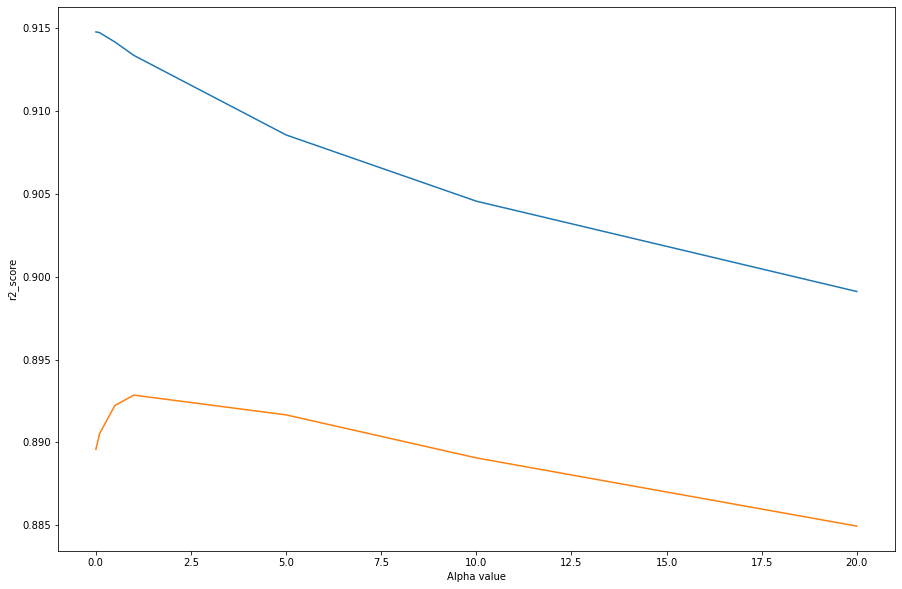

In [52]:
plt.figure(figsize=(15,10))
plt.plot(cv_res_2['param_alpha'],cv_res_2['mean_train_score'])
plt.plot(cv_res_2['param_alpha'],cv_res_2['mean_test_score'])

plt.xlabel('Alpha value')
plt.ylabel('r2_score')
plt.show()

Checking for the best value of hyperparameter now.

In [53]:
model_cv.best_params_

{'alpha': 1.0}

Fitting the ridge model with this hyperparameter,

In [54]:
ridge = Ridge(alpha = 1.0)
ridge.fit(X_train,y_train)

y_pred_train = ridge.predict(X_train)
print(r2_score(y_train,y_pred_train))

y_pred_test = ridge.predict(X_test)
print(r2_score(y_test,y_pred_test))

0.9129083977047581
0.8668865122875082


- Hence, we can see that there is not much difference with Lasso/Ridge regression, the r2 scores are nearly same. But using Lasso regression can be helpful in feature elimination and hence, in my final model, I choose Lasso one.

- From both the models, by the coefficients, we can observe that __MSSubClass, BsmtCond, LotArea, LotShape, BsmtExposure__ are the factors which affect the SalePrice of the house significantly. (Arranged in decreasing order of significance)

- Best value of alpha in Lasso: 0.001, in Ridge: 1.0